<a href="https://colab.research.google.com/github/TJSun009/University-Projects/blob/main/Test_Categorisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble
This model is designed to look at categorising unit tests in order to perform downstream tasks (such as mapping test types to certain actions)

List of sources used:


*   [https://www.geeksforgeeks.org/unit-testing-software-testing](https://www.geeksforgeeks.org/unit-testing-software-testing)
*   [https://www.javatpoint.com/unit-testing](https://www.javatpoint.com/unit-testing)
*   [https://www.imperva.com/learn/application-security/black-box-testing](https://www.imperva.com/learn/application-security/black-box-testing)
*   [https://www.imperva.com/learn/application-security/white-box-testing/](https://www.imperva.com/learn/application-security/white-box-testing/)



Broadly speaking documentation  refers to three broad unit test types:


* Black Box Testing - Testing a system with no knowledge of its internals
    * This involves testing the user interface i.e input and outputs
    * **Utility** - checks that the *system as a whole is working* as expected
    * Example: 
        * checking that it is possible to log in using correct user credentials, and not possible to log in using wrong credentials.
    * Includes checking:
        * input/output **formats** (length and REGEX)
        * **boundary** values
* White Box Testing - Testing a system with knowledge of internals (source code, documentation etc.)
    * This involves testing behaviour of the system from developer perspective
    * **Utility** - can uncover structural problems, hidden errors and problems with specific components; ensures code is comprehensively covered
    * Example:
        * 
    * Includes checking:
        * **security vulnerabilities**
        * **loop testing**
        * **types**
        * **data flow**
        * **control flow** - order of execution
    * Code coverage Techniques:
        * **branch coverage**
        * **statement coverage**
        * **path coverage** - looking at executed code paths and their relevance
* Gray Box Testing - Testing with partial knowledge of the system's internals
    * It's a combination of White and Gray Box Testing




# Assumptions
Given that we will be using the source code we can assume our tests will either be White or Grey Box

The most common tests expected to come up are:

* Bounds Testing
* Branching Statements
* Loop Testing
* Format
* Error

The basic things that will be checked are:
(Fundamental to code itself)
* Return type, length, value
* Function calls, call order
* Exception raised, type
* Class Instantiation (built on type-checks etc)
* Inclusion or exclusion after state update (lists, sets)

# Test 1

We'll work with the pyUnittest_Tutorial which provides source code and tests for a simple calculator

Our work assumes both the code and tests are correct and functioning

## Start with two generic labels

In [11]:
labels = [
    "value_check",
    "type_check",
    "length_check",
    "function_call",
    "exception_raised",
    "modified_state"
    ]

# New Task - Looking to Map source and test graph to one another

## Import Test Dataset

## Import libraries

### Graph generator Setup

In [13]:
#@title Git Config
import getpass
!git config --global user.email "emmanuelo009.oe@gmail.com"
!git config --global user.name "TJSun009"

TARGET_DIR = "/content/typilus"
BRANCH_NAME = "time.clock-bugfix"
ACCESS_TOKEN = getpass.getpass()
REMOTE = f"https://{ACCESS_TOKEN}@github.com/TJSun009/typilus.git"

··········


In [14]:
#@title Typilus Forked Bugfix Branch

!git clone https://github.com/TJSun009/typilus.git

!(cd {TARGET_DIR}/; \
git pull {REMOTE} {BRANCH_NAME}; \
git checkout {BRANCH_NAME})

fatal: destination path 'typilus' already exists and is not an empty directory.
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `(cd /content/typilus/;  git pull https://len(graphToJson("/content/pyUnittest_Tutorial/all-graphs000.jsonl.gz")[0]["nodes"])@github.com/TJSun009/typilus.git time.clock-bugfix;  git checkout time.clock-bugfix)'


In [80]:
#@title Add to Path
import sys

GRAPH_GENERATOR_PATH = "/content/typilus/src/data_preparation/scripts/graph_generator"

#change graphgenerator to module
!touch {GRAPH_GENERATOR_PATH}/__init__.py

DATASET_FOLDER = "/content/drive/MyDrive/Year 3/Dissertation/Projects/Datasets/data/minified"
TYPING_RULES_PATH = "/content/typilus/src/data_preparation/metadata/typingRules.json"
CORPUS_DUPLICATES = "/content/drive/MyDrive/Year 3/Dissertation/Projects/corpus_duplicates.json"

if (GRAPH_GENERATOR_PATH not in sys.path):
  sys.path.append(f"{GRAPH_GENERATOR_PATH}")

### Graph generator Functions

In [81]:
!pip install -Uqqq dpu_utils typed_ast
import extract_graphs, os, gzip, json


def generate_graphs(src, dest = 0):
  dest = src if dest == 0 else dest
  extract_graphs.main({
      "SOURCE_FOLDER": src,
      "SAVE_FOLDER": dest,
      "TYPING_RULES": TYPING_RULES_PATH,
      "DUPLICATES_JSON": CORPUS_DUPLICATES
  })

def graphToJson(file):
  json_content = []
  with gzip.open(file) as f:
    for line in f:
      line = line.rstrip()
      if line:
        obj = json.loads(line)
        json_content.append(obj)
  return json_content

In [99]:
TEST_DATA = os.path.join(DATASET_FOLDER, "test", "")
TEST_GRAPH = os.path.join(TEST_DATA, "graph", "all-graphs000.jsonl.gz")

if not os.path.isfile(TEST_GRAPH):
  generate_graphs(TEST_DATA, os.path.join(TEST_DATA, "graph", ""))

SRC_DATA = os.path.join(DATASET_FOLDER, "src", "")
SRC_GRAPH = os.path.join(SRC_DATA, "graph", "all-graphs000.jsonl.gz")

print(SRC_GRAPH)
if not os.path.isfile(SRC_GRAPH):
  generate_graphs(SRC_DATA, os.path.join(SRC_DATA, "graph", ""))

/content/drive/MyDrive/Year 3/Dissertation/Projects/Datasets/data/minified/src/graph/all-graphs000.jsonl.gz
Exploring folders ...
/content/drive/MyDrive/Year 3/Dissertation/Projects/Datasets/data/minified/src/twisted.py
Building type graph for project... (0 elements to process)
Done building type graph
Traceback (most recent call last):
  File "/content/typilus/src/data_preparation/scripts/graph_generator/extract_graphs.py", line 55, in build_graph
    return visitor.build()
  File "/content/typilus/src/data_preparation/scripts/graph_generator/graphgenerator.py", line 111, in build
    self.visit(self.__ast)
  File "/content/typilus/src/data_preparation/scripts/graph_generator/graphgenerator.py", line 212, in visit
    return visitor(node)
  File "/content/typilus/src/data_preparation/scripts/graph_generator/graphgenerator.py", line 605, in visit_Module
    self.generic_visit(node)
  File "/usr/local/lib/python3.8/dist-packages/typed_ast/ast3.py", line 287, in generic_visit
    self.vi

In [101]:
print(len(graphToJson(TEST_GRAPH)), len(graphToJson(SRC_GRAPH)))

38 22


In [19]:
len(graphToJson("/content/pyUnittest_Tutorial/all-graphs000.jsonl.gz")[0]["nodes"])

282

In [55]:
len(graphToJson("/content/pyUnittest_Tutorial/all-graphs000.jsonl.gz"))

2

In [ ]:
graphToJson("/content/pyUnittest_Tutorial/all-graphs000.jsonl.gz")

## Generate Graphs

## Feed Data to Graph Network

In [22]:
! pip install -Uqqq scipy

     |████████████████████████████████| 33.8 MB 433 kB/s 


In [24]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import networkx as nx

### Helper Functions

### Creating CodeGraph Class

This class makes use of networkx a popular graph representation library

In [67]:
# each edge should be weighted differently based on its type, edge should contain types

# This code graph class represents a combination of all the graphs generated in the code corpus
class CodeGraph:

  def __init__(self):
    self.G = nx.MultiDiGraph()
    self.vocab = []
    self.edge_types = []
    self.graph_type = "typilus"

  def read(self, json_path):
    temp = graphToJson(json_path)

    # single graph toggle
    # temp = [temp[0]]

    # graph node offset for combining graphs
    multigraph_node_offset = 0

    for graph in temp:
      
      # function to check or a super node
      def is_super(node):
        return 1 if str(node) in graph["supernodes"].keys() else 0

      # add nodes to graph and to vocab for later tokenisation
      nodes = graph["nodes"]
      for idx, node in enumerate(nodes):
        self.G.add_node(idx + multigraph_node_offset, value=node, super=is_super(idx))
        if node not in self.vocab:
          self.vocab.append(node)
      
      
      # append edges to the graph along with their types
      for idx, edge_type in enumerate(graph["edges"]):
        self.edge_types.append(edge_type)
        for source, targets in list(graph["edges"][edge_type].items()):
          # careful with conversion of source keys to integers
          self.G.add_edges_from([(int(source) + multigraph_node_offset, target  + multigraph_node_offset, {"type": idx}) for target in targets])
      
      # update global node offset
      multigraph_node_offset += len(nodes)

  def draw(self):
    if len(self.G.nodes) > 0:
      # create normalizer for colours
      norm = plt.Normalize()

      # use vocab and edge_types to generate colours for plot
      token_colors = [self.vocab.index(val) for val in list(nx.get_node_attributes(self.G, "value").values())]
      edge_type_colors = list(nx.get_edge_attributes(self.G, "type").values())

      # normalize the colors between [0, 1]
      node_color, edge_color = norm(token_colors), norm(edge_type_colors)

      fig, ax = plt.subplots(1, 1, figsize=(10, 10));

      nx.draw_networkx(self.G, edge_color = edge_color, node_color = node_color, with_labels=True, ax = ax)
  
  # split the graph based on it's supernodes
  def get_sub_graphs(self):
    if len(self.G.nodes) > 0:
      components = list(nx.weakly_connected_components(G))
      return [self.G.subgraph(c) for c in components]
      # visualisation of subgraphs
      # fig, ax = plt.subplots(1, len(components), figsize=(10 * len(components), 10));

      # intersect = set(components[0])
      # # intersect = nx.intersection_all(components)

      # for idx, c in enumerate(components):
      #   print(idx)
      #   intersect = intersect.intersection(c)
      #   nx.draw_networkx(G.subgraph(c), with_labels=True, ax=ax[idx])

      # print(intersect)

In [68]:
from networkx.generators import intersection
cg = CodeGraph()

PY_TEST_DIR = "/content/pyUnittest_Tutorial/all-graphs000.jsonl.gz"

cg.read(PY_TEST_DIR)
# len(G.vocab)
# len(G.G.nodes)
# cg.draw()

G = cg.G

#### Viz Supernodes

{0, 4, 5, 6, 7, 8, 9, 10, 267, 268, 13, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 272, 277, 278, 279, 280, 251, 252}
{0: '', 4: '', 5: '', 6: '', 7: '', 8: '', 9: '', 10: '', 267: '', 268: '', 13: '', 12: '', 15: '', 16: '', 17: '', 18: '', 19: '', 20: '', 21: '', 22: '', 23: '', 24: (24, 'setUp'), 272: '', 277: '', 278: '', 279: '', 280: '', 251: '', 252: ''}


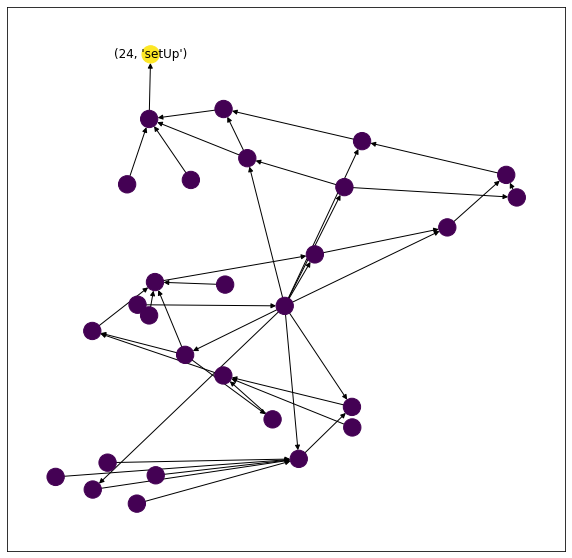

In [58]:
node = 24
descendants = nx.ancestors(G, node)
print(descendants)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

H = nx.induced_subgraph(G, set([node]).union(descendants))
H_labels = {k: (k, v) if (k == node) else "" for k,v in list(nx.get_node_attributes(H, "value").items())}
print(H_labels)
nx.draw_networkx(H, labels = H_labels, ax = ax, node_color=[i==node for i in H.nodes])

#### PyTorch Conversion

In [61]:
import torch
print("PyTorch has version {}".format(torch.__version__))

PyTorch has version 1.13.0+cu116


In [62]:
!pip install -Uqqq torch-scatter torch-sparse torch-geometric -f https://pytorch-geometric.com/whl/torch-1.13.0+cu116.html

     |████████████████████████████████| 9.4 MB 7.8 MB/s 
     |████████████████████████████████| 4.5 MB 58.8 MB/s 


In [69]:
from torch_geometric.utils.convert import from_networkx
torch_graph = from_networkx(G)
print(torch_graph.super)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Prep Datasets


*   Test and Train Features



In [ ]:
num_classes = len(labels)

## Create Feed Forward Network

In [ ]:
def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        # Batch Normalization normalizes unit values in batches (using its mean and standard dev) to create even spread 
        fnn_layers.append(layers.BatchNormalization())
        # Dropout removes units randomly to prevent overfitting
        fnn_layers.append(layers.Dropout(dropout_rate))
        # Dense layer every node conected to the others
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)

## Create Train and Evaluation Experiment

In [ ]:
# Train and Arch variables
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

In [ ]:
def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history

In [ ]:
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

## Create Graph Convolutional Layer

In [ ]:
class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        # used to aggregate node messages
        aggregation_type="mean",
        # used to combine node representations with their messages
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super(GraphConvLayer, self).__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gated":
            self.update_fn = layers.GRU(
                units=hidden_units,
                activation="tanh",
                recurrent_activation="sigmoid",
                dropout=dropout_rate,
                return_state=True,
                recurrent_dropout=dropout_rate,
            )
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim]
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)

## Create GNN Classifier

In [ ]:
class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super(GNNNodeClassifier, self).__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        print(self.node_features)
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)

## Instantiate GNN Classifier

In [ ]:
def trainOnGraphs(graphs):
  x_train, y_train = [], []
  
  for graph in graphs:
    graph_dict = transformGraphForGNN(graph)

    x_train.append(np.array([node_feature for node_feature in graph_dict["info"]["node_features"]]))
    y_train.append(labels.index(graph_dict["label"]))
    # for node_feature in graph_dict["info"]["node_features"]:
    #   x_train.append(node_feature)
    # y_train.append([labels.index(graph_dict["label"])])

  x_train = tf.cast(
      np.array(x_train, dtype=np.float32), 
      dtype=tf.dtypes.float32
  )
  # print(x_train)

  y_train = np.array(y_train, dtype=np.float32)
  # print(y_train)

  # x_train = np.array([1,1,1,1])
  # y_train = np.array([1, 0, 1, 0])

  print(graph_dict["info"].values())

  gnn_model = GNNNodeClassifier(
    graph_info=tuple(graph_dict["info"].values()),
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
  )

  # print("GNN output shape:", gnn_model(tf.constant([1, 10])))

  # gnn_model.summary()

   # print("GNN output shape:", gnn_model(np.asarray([1, 10, 100])))

  return run_experiment(gnn_model, x_train, y_train)

import json

HISTORY_PATH = "/content/history.json"

history = trainOnGraphs(graphs).history

# json.dump(history, open(HISTORY_PATH, "w+"))

print(history)

dict_values([array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=object), array([[  0,   0,   0,   1,   4,   4,   4,   4,   4,   4,   4,   4,   4,
          4,   8,   8,   8,   9,  17,  17,  17,  17,  17,  17,  17,  17,
         22,  22,  23,  29,  29,  29,  29,  29,  30,  36,  36,  36,  38,
         45,  45,  45,  45,  45,  45,  45,  45,  45,  45,  50,  50,  51,
         57,  57,  57,  58,  61,  61,  61,  61,  61,  61,  63,  63,  63,
         64,  64,  64,  65,  73,  76,  80,  81,  81,  81,  81,  81,  81,
         82,  82,  82,  83,  89,  92,   5,   6,   7,  10,  12,  13,  15,
         16,  18,  19,  21,  24,  26,  27,  28,  31,  32,  33,  37,  39,
         41,  42,  43,  44,  46,  47,  49,  52,  54,  55,  56,  59,  62,
         66,  67,  68,  69,  70,  72,  74,  75,  77,  78,  79,  84,  85,
         86,  88,  90,  91,  93,  57,

TypeError: ignored